In [1]:
from IPython.display import HTML
import folium
import random as RD
import pandas as pd
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))

def embed_map(map, path="map.html"):
    """
    Embeds a linked iframe to the map into the IPython notebook.
    
    Note: this method will not capture the source of the map into the notebook.
    This method should work for all maps (as long as they use relative urls).
    """
    map.create_map(path=path)
    return HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path=path))

## Base layer for south

In [3]:
import folium
map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5)
map_osm.geo_json(geo_path = 'data/south.json')
embed_map(map_osm)

## Binding Attribute Data to the Map

In [4]:
import json

f = open(r'data/south.json')
q = json.load(f)
f.close()

In [5]:
q.keys()

[u'type', u'features']

In [6]:
features = q['features']
len(features)

1412

In [7]:
import pandas as pd
indices = []
values = []
for feature in features:
    indices.append(str(feature['properties']['FIPS']))
    values.append(feature['properties']['HR80'])

In [8]:
df = pd.DataFrame({'HR80': values,
                   'FIPS': indices} )

In [9]:
y = np.array(df.HR80.tolist())

In [10]:
import numpy as np
import pysal as ps
w = ps.queen_from_shapefile('data/south.shp')
w.transform = 'r'

In [11]:
y = np.array(df['HR80'].tolist())

## Local Moran
$li_i = \frac{n-1}{\sum_j z_j^2}z_i \sum_j w_{i,j} z_j$

In [12]:
li_hr80 = ps.Moran_Local(y,w)

In [13]:
li_hr80.p_sim.shape

(1412,)

In [14]:
sig01 = 1.* (li_hr80.p_sim<=0.01)

In [15]:
sig01.sum()

160.0

In [16]:
sig05 = 1.* (li_hr80.p_sim<=0.05)

In [17]:
sig05.sum()

377.0

In [18]:
df['sig01']  = sig01
df['sig05'] = sig05

In [19]:

map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5,)
map_osm.geo_json(geo_path='data/south.json',
                 key_on='feature.properties.FIPS',
                 data_out='data.json', data=df,
                 columns=['FIPS','HR80'],
                 fill_color='YlGnBu', fill_opacity=0.7,
                 line_opacity=0.2,
                 legend_name='Homicide Rate HR80')
embed_map(map_osm)

In [20]:

map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5,)
map_osm.geo_json(geo_path='data/south.json',
                 key_on='feature.properties.FIPS',
                 data_out='data.json', data=df,
                 columns=['FIPS','sig01'],
                 fill_color='YlOrRd', fill_opacity=0.7,
                 line_opacity=0.2,
                 threshold_scale=[0,1],
                 legend_name='Homicide Rate HR80 - Significant LISA (0.01)')
embed_map(map_osm)

In [21]:

map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5,)
map_osm.geo_json(geo_path='data/south.json',
                 key_on='feature.properties.FIPS',
                 data_out='data.json', data=df,
                 columns=['FIPS','sig01'],
                 fill_color='YlOrRd', fill_opacity=0.7,
                 line_opacity=0.2,
                 legend_name='Homicide Rate HR80 - Significant LISA (0.01)')
embed_map(map_osm)

In [22]:

map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5,)
map_osm.geo_json(geo_path='data/south.json',
                 key_on='feature.properties.FIPS',
                 data_out='data.json', data=df,
                 columns=['FIPS','sig05'],
                 fill_color='YlOrRd', fill_opacity=0.7,
                 line_opacity=0.2,
                 legend_name='Homicide Rate HR80 - Significant LISA (0.05)')
embed_map(map_osm)

In [23]:
li_hr80.q

array([3, 3, 3, ..., 3, 3, 3])

In [24]:
cold_spots = 1. * (li_hr80.q==3) * (li_hr80.p_sim < 0.01)

In [25]:
cold_spots.sum()

59.0

In [26]:
# Cold spots in pandas'y way
lisa_df = pd.DataFrame({'q': li_hr80.q, 'p_sim': li_hr80.p_sim})
cold = lisa_df[(lisa_df['q']==3) & (lisa_df['p_sim']<0.01)]
print cold.info()
print '\n~~~~~~~~~~\n'
# Hot spots in pandas'y way
hot = lisa_df[(lisa_df['q']==1) & (lisa_df['p_sim']<0.01)]
print hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 6 to 1286
Data columns (total 2 columns):
p_sim    59 non-null float64
q        59 non-null int64
dtypes: float64(1), int64(1)None

~~~~~~~~~~

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 199 to 1401
Data columns (total 2 columns):
p_sim    54 non-null float64
q        54 non-null int64
dtypes: float64(1), int64(1)None


In [27]:
hot_spots = 1. * (li_hr80.q==1) * (li_hr80.p_sim < 0.01)

In [28]:
hot_spots.sum()

54.0

In [29]:
df['hot_01'] = hot_spots
df['cold_01'] = cold_spots

In [30]:
df.hot_01

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
...
1397    1
1398    0
1399    1
1400    0
1401    1
1402    0
1403    0
1404    0
1405    0
1406    0
1407    0
1408    0
1409    0
1410    0
1411    0
Name: hot_01, Length: 1412, dtype: float64

In [31]:
df.cold_01

0     0
1     0
2     0
3     0
4     0
5     0
6     1
7     0
8     1
9     0
10    1
11    1
12    0
13    0
14    1
...
1397    0
1398    0
1399    0
1400    0
1401    0
1402    0
1403    0
1404    0
1405    0
1406    0
1407    0
1408    0
1409    0
1410    0
1411    0
Name: cold_01, Length: 1412, dtype: float64

In [32]:

map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5,)
map_osm.geo_json(geo_path='data/south.json',
                 key_on='feature.properties.FIPS',
                 data_out='data.json', data=df,
                 columns=['FIPS','hot_01'],
                 fill_color='YlOrRd', fill_opacity=0.7,
                 line_opacity=0.2,
                 threshold_scale=[0,1],
                 legend_name='Homicide Rate HR80 - Hot Spots (0.01)')
embed_map(map_osm)

In [33]:

map_osm = folium.Map(location=[33.7550, -87.3900], zoom_start=5,)
map_osm.geo_json(geo_path='data/south.json',
                 key_on='feature.properties.FIPS',
                 data_out='data.json', data=df,
                 columns=['FIPS','cold_01'],
                 fill_color='YlGnBu', fill_opacity=0.7,
                 line_opacity=0.2,
                 threshold_scale=[0,1],
                 legend_name='Homicide Rate HR80 - Cold Spots (0.01)')
embed_map(map_osm)

In [34]:
dbf = ps.open('data/south.dbf')
dbf.header

['NAME',
 'STATE_NAME',
 'STATE_FIPS',
 'CNTY_FIPS',
 'FIPS',
 'STFIPS',
 'COFIPS',
 'FIPSNO',
 'SOUTH',
 'HR60',
 'HR70',
 'HR80',
 'HR90',
 'HC60',
 'HC70',
 'HC80',
 'HC90',
 'PO60',
 'PO70',
 'PO80',
 'PO90',
 'RD60',
 'RD70',
 'RD80',
 'RD90',
 'PS60',
 'PS70',
 'PS80',
 'PS90',
 'UE60',
 'UE70',
 'UE80',
 'UE90',
 'DV60',
 'DV70',
 'DV80',
 'DV90',
 'MA60',
 'MA70',
 'MA80',
 'MA90',
 'POL60',
 'POL70',
 'POL80',
 'POL90',
 'DNL60',
 'DNL70',
 'DNL80',
 'DNL90',
 'MFIL59',
 'MFIL69',
 'MFIL79',
 'MFIL89',
 'FP59',
 'FP69',
 'FP79',
 'FP89',
 'BLK60',
 'BLK70',
 'BLK80',
 'BLK90',
 'GI59',
 'GI69',
 'GI79',
 'GI89',
 'FH60',
 'FH70',
 'FH80',
 'FH90']

In [35]:
 df['STATE_NAME'] = dbf.by_col('STATE_NAME')

In [36]:
df['County'] = dbf.by_col('NAME')

In [37]:
hot_01 = df['hot_01']

In [38]:
hot  = df[hot_01>0]

In [39]:
hot

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
199,21025,19.603231,1,1,1,0,Kentucky,Breathitt
231,21193,37.516413,1,1,1,0,Kentucky,Perry
240,21051,29.301453,1,1,1,0,Kentucky,Clay
247,21131,38.077319,1,1,1,0,Kentucky,Leslie
285,21095,20.689600,1,1,1,0,Kentucky,Harlan
305,21013,19.419361,1,1,1,0,Kentucky,Bell
712,28027,15.349333,1,1,1,0,Mississippi,Coahoma
752,45041,15.734260,1,1,1,0,South Carolina,Florence
804,48387,10.351324,1,1,1,0,Texas,Red River
850,28015,10.229133,1,1,1,0,Mississippi,Carroll


In [40]:
df[['STATE_NAME', 'County']]

,STATE_NAME,County
0,West Virginia,Hancock
1,West Virginia,Brooke
2,West Virginia,Ohio
3,West Virginia,Marshall
4,Delaware,New Castle
5,Maryland,Washington
6,Maryland,Allegany
7,Maryland,Cecil
8,Maryland,Garrett
9,Maryland,Harford


In [41]:
df.head()

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
0,54029,6.597720,0,0,0,0,West Virginia,Hancock
1,54009,3.213677,0,0,0,0,West Virginia,Brooke
2,54069,7.601796,0,0,0,0,West Virginia,Ohio
3,54051,4.005640,0,0,0,0,West Virginia,Marshall
4,10003,7.116872,0,0,0,0,Delaware,New Castle


In [42]:
df.tail()

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
1407,51083,15.034136,0,0,0,0,Virginia,Halifax
1408,51163,3.967782,0,0,0,0,Virginia,Rockbridge
1409,51161,4.127839,0,0,0,0,Virginia,Roanoke
1410,51199,5.280349,0,0,0,0,Virginia,York
1411,51153,3.000030,0,0,0,0,Virginia,Prince William


In [43]:
df[[0,2,4]]

,FIPS,sig01,hot_01
0,54029,0,0
1,54009,0,0
2,54069,0,0
3,54051,0,0
4,10003,0,0
5,24043,1,0
6,24001,1,0
7,24015,0,0
8,24023,1,0
9,24025,0,0


In [44]:
df[df.hot_01 > 0 ].all()

FIPS           True
HR80           True
sig01          True
sig05          True
hot_01         True
cold_01       False
STATE_NAME     True
County         True
dtype: bool

In [45]:
df[0:10]

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
0,54029,6.597720,0,0,0,0,West Virginia,Hancock
1,54009,3.213677,0,0,0,0,West Virginia,Brooke
2,54069,7.601796,0,0,0,0,West Virginia,Ohio
3,54051,4.005640,0,0,0,0,West Virginia,Marshall
4,10003,7.116872,0,0,0,0,Delaware,New Castle
5,24043,2.063326,1,1,0,0,Maryland,Washington
6,24001,3.724487,1,1,0,1,Maryland,Allegany
7,24015,6.067626,0,0,0,0,Maryland,Cecil
8,24023,5.031826,1,1,0,1,Maryland,Garrett
9,24025,3.426300,0,0,0,0,Maryland,Harford


In [46]:
hot = df[df['hot_01']>0]

In [47]:
hot

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
199,21025,19.603231,1,1,1,0,Kentucky,Breathitt
231,21193,37.516413,1,1,1,0,Kentucky,Perry
240,21051,29.301453,1,1,1,0,Kentucky,Clay
247,21131,38.077319,1,1,1,0,Kentucky,Leslie
285,21095,20.689600,1,1,1,0,Kentucky,Harlan
305,21013,19.419361,1,1,1,0,Kentucky,Bell
712,28027,15.349333,1,1,1,0,Mississippi,Coahoma
752,45041,15.734260,1,1,1,0,South Carolina,Florence
804,48387,10.351324,1,1,1,0,Texas,Red River
850,28015,10.229133,1,1,1,0,Mississippi,Carroll


In [48]:
df[df['hot_01']>0]

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
199,21025,19.603231,1,1,1,0,Kentucky,Breathitt
231,21193,37.516413,1,1,1,0,Kentucky,Perry
240,21051,29.301453,1,1,1,0,Kentucky,Clay
247,21131,38.077319,1,1,1,0,Kentucky,Leslie
285,21095,20.689600,1,1,1,0,Kentucky,Harlan
305,21013,19.419361,1,1,1,0,Kentucky,Bell
712,28027,15.349333,1,1,1,0,Mississippi,Coahoma
752,45041,15.734260,1,1,1,0,South Carolina,Florence
804,48387,10.351324,1,1,1,0,Texas,Red River
850,28015,10.229133,1,1,1,0,Mississippi,Carroll


In [49]:
df[df['cold_01']>0]

,FIPS,HR80,sig01,sig05,hot_01,cold_01,STATE_NAME,County
6,24001,3.724487,1,1,0,1,Maryland,Allegany
8,24023,5.031826,1,1,0,1,Maryland,Garrett
10,54061,4.443023,1,1,0,1,West Virginia,Monongalia
11,54077,1.094331,1,1,0,1,West Virginia,Preston
14,54103,4.571638,1,1,0,1,West Virginia,Wetzel
15,24021,3.194183,1,1,0,1,Maryland,Frederick
16,54065,6.224131,1,1,0,1,West Virginia,Morgan
20,54095,0.000000,1,1,0,1,West Virginia,Tyler
23,54073,0.000000,1,1,0,1,West Virginia,Pleasants
24,54033,6.005233,1,1,0,1,West Virginia,Harrison


In [50]:
print df[df['cold_01']>0].to_string() 

       FIPS       HR80  sig01  sig05  hot_01  cold_01     STATE_NAME        County
6     24001   3.724487      1      1       0        1       Maryland      Allegany
8     24023   5.031826      1      1       0        1       Maryland       Garrett
10    54061   4.443023      1      1       0        1  West Virginia    Monongalia
11    54077   1.094331      1      1       0        1  West Virginia       Preston
14    54103   4.571638      1      1       0        1  West Virginia        Wetzel
15    24021   3.194183      1      1       0        1       Maryland     Frederick
16    54065   6.224131      1      1       0        1  West Virginia        Morgan
20    54095   0.000000      1      1       0        1  West Virginia         Tyler
23    54073   0.000000      1      1       0        1  West Virginia     Pleasants
24    54033   6.005233      1      1       0        1  West Virginia      Harrison
26    54017   4.484506      1      1       0        1  West Virginia     Doddridge
27  

In [51]:
hot_01

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
...
1397    1
1398    0
1399    1
1400    0
1401    1
1402    0
1403    0
1404    0
1405    0
1406    0
1407    0
1408    0
1409    0
1410    0
1411    0
Name: hot_01, Length: 1412, dtype: float64

In [52]:
y

array([ 6.59772049,  3.21367741,  7.6017962 , ...,  4.12783918,
        5.2803488 ,  3.00003   ])

In [53]:
w = ps.queen_from_shapefile('data/south.shp')
w.transform = 'r'
wy = ps.lag_spatial(w,y)

/home/serge/anaconda/lib/python2.7/site-packages/pysal/spreg/user_output.py:349: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if i == None:


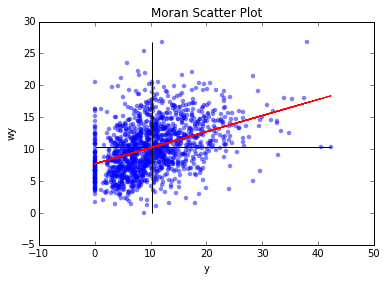

In [54]:
scatter(y,wy, alpha=0.5, lw=0)
vlines(y.mean(),wy.min(),wy.max())
hlines(wy.mean(),y.min(),y.max())
xlabel('y')
ylabel('wy')
lm = ps.spreg.OLS(wy[:, None], y[:, None])
plot(y, lm.predy, color='red')
title('Moran Scatter Plot')
show()

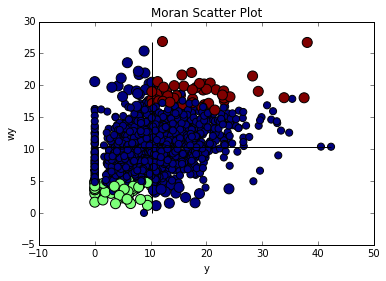

In [55]:
c = 2*hot_01 + df.cold_01
scatter(y,wy, c=c, s=(sig01+1)*50)
vlines(y.mean(),wy.min(),wy.max())
hlines(wy.mean(),y.min(),y.max())
xlabel('y')
ylabel('wy')
title('Moran Scatter Plot')

In [56]:
sig01.sum()

160.0

In [57]:
df['wHR80'] = wy

In [58]:
print df[df['cold_01']>0].to_string() 

       FIPS       HR80  sig01  sig05  hot_01  cold_01     STATE_NAME        County     wHR80
6     24001   3.724487      1      1       0        1       Maryland      Allegany  3.153441
8     24023   5.031826      1      1       0        1       Maryland       Garrett  3.527749
10    54061   4.443023      1      1       0        1  West Virginia    Monongalia  2.932325
11    54077   1.094331      1      1       0        1  West Virginia       Preston  3.642804
14    54103   4.571638      1      1       0        1  West Virginia        Wetzel  3.831961
15    24021   3.194183      1      1       0        1       Maryland     Frederick  4.037935
16    54065   6.224131      1      1       0        1  West Virginia        Morgan  3.416385
20    54095   0.000000      1      1       0        1  West Virginia         Tyler  2.992347
23    54073   0.000000      1      1       0        1  West Virginia     Pleasants  1.682967
24    54033   6.005233      1      1       0        1  West Virginia  

In [59]:
print df[df['hot_01']>0].to_string() 

       FIPS       HR80  sig01  sig05  hot_01  cold_01      STATE_NAME        County      wHR80
199   21025  19.603231      1      1       1        0        Kentucky     Breathitt  20.213720
231   21193  37.516413      1      1       1        0        Kentucky         Perry  18.053386
240   21051  29.301453      1      1       1        0        Kentucky          Clay  19.064651
247   21131  38.077319      1      1       1        0        Kentucky        Leslie  26.731707
285   21095  20.689600      1      1       1        0        Kentucky        Harlan  20.361694
305   21013  19.419361      1      1       1        0        Kentucky          Bell  19.268191
712   28027  15.349333      1      1       1        0     Mississippi       Coahoma  18.435638
752   45041  15.734260      1      1       1        0  South Carolina      Florence  15.955423
804   48387  10.351324      1      1       1        0           Texas     Red River  19.645064
850   28015  10.229133      1      1       1      

In [60]:
lg = ps.G_Local(y, w)

In [61]:
lg.n

1412

In [62]:
sig = lg.p_sim < 0.01

In [63]:
sig

array([False, False, False, ..., False, False, False], dtype=bool)

In [64]:
lg.p_sim[sig]

array([ 0.009,  0.001,  0.003,  0.006,  0.002,  0.005,  0.006,  0.008,
        0.007,  0.003,  0.001,  0.008,  0.002,  0.003,  0.008,  0.002,
        0.008,  0.002,  0.007,  0.006,  0.002,  0.006,  0.007,  0.003,
        0.003,  0.009,  0.007,  0.003,  0.001,  0.006,  0.009,  0.004,
        0.001,  0.001,  0.005,  0.005,  0.001,  0.008,  0.006,  0.009,
        0.009,  0.001,  0.003,  0.001,  0.002,  0.001,  0.005,  0.004,
        0.001,  0.001,  0.003,  0.003,  0.002,  0.002,  0.001,  0.008,
        0.008,  0.007,  0.002,  0.003,  0.008,  0.005,  0.008,  0.008,
        0.002,  0.007,  0.004,  0.005,  0.006,  0.003,  0.004,  0.009,
        0.003,  0.004,  0.002,  0.005,  0.001,  0.001,  0.005,  0.006,
        0.003,  0.007,  0.004,  0.002,  0.004,  0.006,  0.006,  0.008,
        0.006,  0.001,  0.001,  0.003,  0.004,  0.006,  0.004,  0.003,
        0.001,  0.003,  0.001,  0.005,  0.005,  0.004,  0.001,  0.001,
        0.002,  0.005,  0.009,  0.007,  0.002,  0.004,  0.009,  0.003,
      

In [65]:
lgs = ps.G_Local(y,w, star=True)

In [66]:
lgs.p_sim[lgs.p_sim < 0.01]

array([ 0.003,  0.005,  0.004,  0.003,  0.004,  0.004,  0.001,  0.005,
        0.001,  0.001,  0.001,  0.009,  0.001,  0.002,  0.004,  0.009,
        0.007,  0.005,  0.008,  0.009,  0.007,  0.005,  0.003,  0.006,
        0.003,  0.002,  0.007,  0.006,  0.001,  0.001,  0.006,  0.002,
        0.001,  0.004,  0.001,  0.003,  0.002,  0.002,  0.001,  0.007,
        0.001,  0.001,  0.001,  0.001,  0.002,  0.002,  0.008,  0.001,
        0.008,  0.005,  0.005,  0.009,  0.001,  0.004,  0.006,  0.006,
        0.006,  0.001,  0.005,  0.007,  0.006,  0.004,  0.002,  0.008,
        0.003,  0.009,  0.009,  0.001,  0.001,  0.003,  0.004,  0.002,
        0.009,  0.006,  0.005,  0.003,  0.006,  0.003,  0.009,  0.004,
        0.003,  0.006,  0.005,  0.004,  0.004,  0.001,  0.002,  0.009,
        0.002,  0.009,  0.008,  0.006,  0.004,  0.001,  0.004,  0.008,
        0.009,  0.008,  0.001,  0.001,  0.002,  0.009,  0.001,  0.008,
        0.004,  0.001,  0.003,  0.006,  0.007,  0.005,  0.001,  0.008,
      

In [67]:
sum(sig)

153

In [68]:
sum(lgs.p_sim < 0.01)

151